In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
np.set_printoptions(suppress=True)
import pandas as pd
from tqdm import tqdm
import h5py

In [2]:
def findpair(ID2,history,possiblecombos):
    if ID2 in list(possiblecombos.ID1):
        #need to consider that there may be more than one possibility for an end point
        #ended up taking the first value because it's the closest in time
        return(findpair(list(possiblecombos.loc[possiblecombos.ID1==ID2].ID2)[0],history+[ID2],possiblecombos))
    else:
        return(history+[ID2])
    
def findpairreverse(ID1,history,possiblecombos):
    if ID1 in list(possiblecombos.ID2):
        #need to consider that there may be more than one possibility for an end point
        #ended up taking the first value because it's the closest in time
        return(findpairreverse(list(possiblecombos.loc[possiblecombos.ID2==ID1].ID1)[0],history+[ID1],possiblecombos))
    else:
        return(history+[ID1])

Import npy file of form (number of points,4) where the second dimension gives 0:id, 1:time, 2:x pos, 3:y pos

In [6]:
tracks=np.load("../../../../../Data/202304051_idtxy.npy")

Finds the distances between consecutive points within and ID and plots the distribution:

In [7]:
dists=np.zeros((np.shape(np.unique(tracks[:,0],return_counts=True))[1],
                np.max(np.unique(tracks[:,0],return_counts=True)[1])))
for i in range(len(np.unique(tracks[:,0]))):
    temptracks=tracks[tracks[:,0]==np.unique(tracks[:,0])[i]]
    for j in range(1,len(temptracks[:,0])):
        dists[i,j]=np.linalg.norm((temptracks[j,2]-temptracks[j-1,2],temptracks[j,3]-temptracks[j-1,3]))

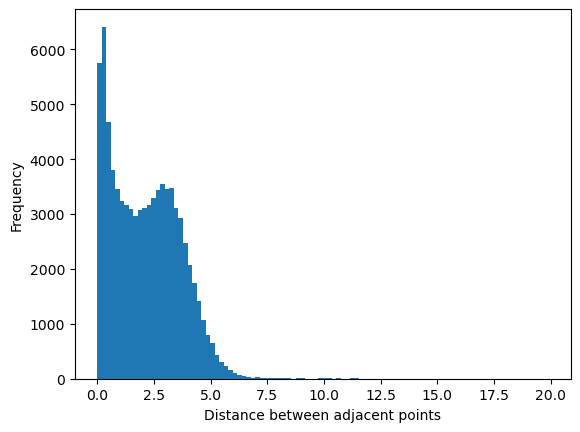

In [8]:
plt.xlabel("Distance between adjacent points")
plt.ylabel("Frequency")
plt.hist(dists[dists!=0],bins=100);

Can't simply remove IDs with little movement because they could be missatributed and actually be part of adjacent worms.

Might be easier to use a pandas dataframe for easier manipulation:

In [9]:
tracksdf=pd.DataFrame(tracks, columns = ['ID','time','x','y'])

We can see that all IDs have consecutive times:

In [10]:
for ID in np.unique(tracksdf.ID):
    l=tracksdf.loc[tracksdf.ID==ID].time.astype(int)
    if not (sorted(l) == list(range(min(l), max(l)+1))): print("Non consecutive")

First, need to make an algorithm that can throw out slow moving worms. We can calculate this by looking a the average angle between points. Slow moving worms will have smaller angles between points.

In [11]:
meanangles=pd.DataFrame(columns=["meanangle"],index=np.unique(tracksdf.ID).astype(int))
for ID in tqdm(np.unique(tracksdf.ID).astype(int)):
    if len(tracksdf.loc[tracksdf.ID==ID])<6:
        meanangles.loc[ID]=120
        continue
    start=int(min(tracksdf.loc[tracksdf.ID==ID].time))
    end=int(max(tracksdf.loc[tracksdf.ID==ID].time))
    #takes three consecutive points in time and calculates the engle between them
    a=tracksdf.loc[(tracksdf.ID==ID)
                   &(start<tracksdf.time)
                   &(tracksdf.time<end-2)]
    b=tracksdf.loc[(tracksdf.ID==ID)
                   &(start+1<tracksdf.time)
                   &(tracksdf.time<end-1)]
    c=tracksdf.loc[(tracksdf.ID==ID)
                   &(start+2<tracksdf.time)
                   &(tracksdf.time<end)]
    meanangles.loc[ID]=np.mean(np.abs(np.degrees(np.arctan2(np.asarray(c.y)-np.asarray(b.y),
                                                                      np.asarray(c.x)-np.asarray(b.x))
                                                           - np.arctan2(np.asarray(a.y)-np.asarray(b.y),
                                                                        np.asarray(a.x)-np.asarray(b.x)))))
    
tracksdf=tracksdf[np.isin(np.asarray(tracksdf.ID),meanangles[meanangles.meanangle>=120].index)]

100%|█████████████████████████████████████████████████████████████████████████████| 1290/1290 [00:02<00:00, 544.22it/s]


Idea for algorithm: find IDs that begin/end on near adjacent times:

In [12]:
#creates dataframe with start and end times for each ID
startend=pd.DataFrame(columns=["start","end"])
for ID in np.unique(tracksdf.ID).astype(int):
    startend.loc[ID,:]=int(np.min(tracksdf.loc[tracksdf.ID==ID].time)),int(np.max(tracksdf.loc[tracksdf.ID==ID].time))
startend.astype(int);

In [13]:
#gets all possible combinations of two indexes within 10 frames and 20 distance
possiblecombos=pd.DataFrame(columns=["ID1","ID2","end","start"])#,"dist"])
for ID in tqdm(np.unique(tracksdf.ID)):
    endindex=startend.loc[ID].end
    endlocation=tracksdf.loc[(tracksdf.ID==ID) & (tracksdf.time==endindex),["x","y"]].values
    for end in range(endindex,endindex+10):
        if end+1 in list(startend.start):
            for startID in startend.index[startend.start==end+1]:
                startlocation=tracksdf.loc[(tracksdf.ID==startID) & (tracksdf.time==end+1),["x","y"]].values
                if np.linalg.norm(startlocation-endlocation) < 20:
                    possiblecombos.loc[len(possiblecombos.index)] = [int(ID),startID,endindex,end+1]#,np.linalg.norm(startlocation-endlocation)] 
                    #print("first ID: "+str(int(ID))+", second ID: "+str(startID)+", difference in times: "+str(endindex),str(end+1)+", distance: "+str(np.linalg.norm(startlocation-endlocation)))

100%|█████████████████████████████████████████████████████████████████████████████| 1137/1137 [00:06<00:00, 177.62it/s]


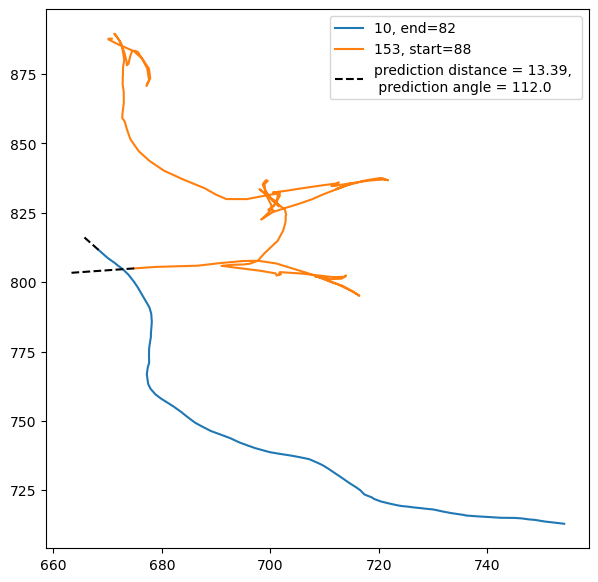

In [14]:
for i in [5]:
    f=plt.figure(figsize=(7,7)) #creates the figure
    
    ID1=int(possiblecombos[possiblecombos.index==i].ID1)#stores IDs for the start and end track
    ID2=int(possiblecombos[possiblecombos.index==i].ID2)#stores IDs for the start and end track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    
    
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

    #plots the two IDs
    plt.plot(tracksdf[tracksdf.ID==ID1].x,
             tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
    plt.plot(tracksdf[tracksdf.ID==ID2].x,
             tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    
    #predicts where the worm should be (halfway)- gives a starting point of the end of ID1 and an ending point that is predicted
    prediction1=np.stack([ID1end,ID1end+diff1*(int(possiblecombos[possiblecombos.index==i].start)
                                              -int(possiblecombos[possiblecombos.index==i].end))/2])
    
    
    #predicts where the worm should be (halfway)- gives a starting point of the end of ID1 and an ending point that is predicted
    prediction2=np.stack([ID2start,ID2start-diff2*(int(possiblecombos[possiblecombos.index==i].start)
                                                  -int(possiblecombos[possiblecombos.index==i].end))/2])
    
    #finds the distance between the predicted points
    dist = np.sqrt(np.sum(np.square(prediction1[1]-prediction2[1])))
    angle = np.min([np.abs(np.arctan2(diff1[1],diff1[0])
                           -np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
                    360-np.abs(np.arctan2(diff1[1],diff1[0])
                               -np.arctan2(diff2[1],diff2[0]))*(180/np.pi)])
    
    #plots the prediction line
    plt.plot(prediction1[:,0],prediction1[:,1],color="black",linestyle="dashed")

    
    plt.plot(prediction2[:,0],prediction2[:,1],color="black",linestyle="dashed",
             label="prediction distance = "+str(np.round(dist,2))+
             ", \n prediction angle = "+str(np.round(angle)))
    
    #print(diff1)
    #print(diff2)
    #print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
    #print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))
    
    #print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
    #              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
    plt.legend()
    plt.show()

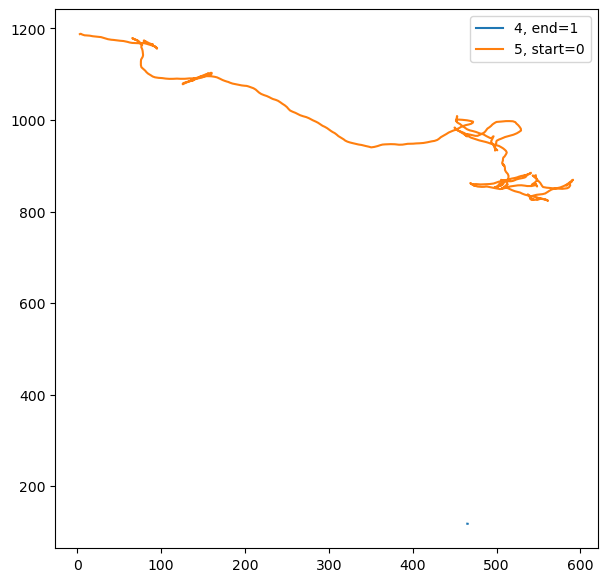

In [43]:
f=plt.figure(figsize=(7,7)) #creates the figure

ID1=4
ID2=5

#finds the difference between the last points of ID1
diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
       -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])


#finds the difference between the first points of ID2
diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
       -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

#plots the two IDs
plt.plot(tracksdf[tracksdf.ID==ID1].x,
         tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
plt.plot(tracksdf[tracksdf.ID==ID2].x,
         tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

#print(diff1)
#print(diff2)
#print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
#print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))

#print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
#              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
plt.legend()
plt.show()

In [39]:
max(tracksdf[tracksdf.ID==2].time.values)

116.0

In [47]:
print(max(tracksdf.x))

1942.65


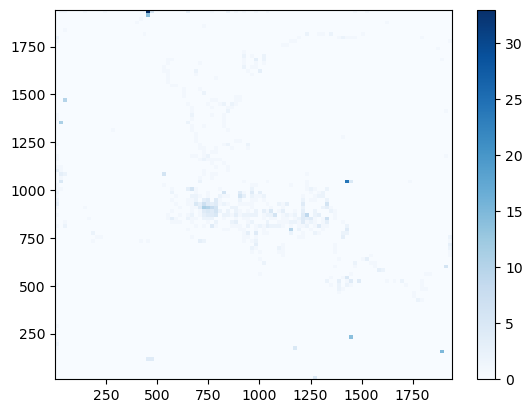

In [71]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()
h = ax.hist2d(xs,ys,bins=100,cmap='Blues')#, norm=LogNorm())
fig.colorbar(h[3], ax=ax)


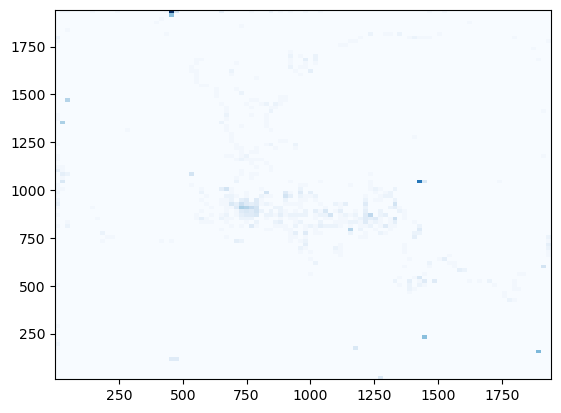

In [79]:
tracksdf[tracksdf.ID==33]

ID   time            x            y
11454  33.0    0.0  1436.750000  1281.600000
11455  33.0    1.0  1437.069767  1281.348837
11456  33.0    2.0  1434.485714  1276.685714
11457  33.0    3.0  1432.133333  1273.766667
11458  33.0    4.0  1429.970588  1271.823529
...     ...    ...          ...          ...
12205  33.0  751.0  1439.350000  1045.250000
12206  33.0  752.0  1438.875000  1045.291667
12207  33.0  753.0  1438.916667  1045.208333
12208  33.0  754.0  1438.714286  1045.142857
12209  33.0  755.0  1438.772727  1045.227273

[756 rows x 4 columns]

In [78]:
xs=[]
ys=[]
for ID in np.unique(tracksdf.ID.values):
    x=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].x.values[0],1)
    y=np.round(tracksdf[(tracksdf.ID==ID)&(tracksdf.time==startend.loc[ID].end)].y.values[0],1)
    xs.append(x)
    ys.append(y)
    if (1250<x and x<1500) and (1000 < y and y < 1250):
        print(str(int(ID))
                  +": "
                  +str(x)
                  +" "
                  +str(y)
                  +", time = "
                  +str(int(startend.loc[ID].end)))

33: 1438.8 1045.2, time = 755
533: 1437.8 1044.6, time = 780
553: 1435.7 1043.7, time = 813
560: 1436.1 1043.9, time = 822
596: 1436.2 1043.9, time = 869
618: 1437.1 1044.5, time = 896
626: 1436.2 1044.1, time = 906
630: 1436.4 1044.1, time = 912
637: 1437.3 1044.5, time = 920
638: 1436.4 1044.1, time = 924
645: 1436.6 1044.2, time = 930
652: 1437.5 1044.7, time = 936
661: 1437.8 1044.7, time = 945
663: 1437.6 1044.7, time = 948
666: 1436.9 1044.3, time = 951
671: 1436.8 1044.2, time = 957
679: 1437.1 1044.4, time = 968
684: 1437.0 1044.3, time = 973
693: 1436.7 1044.1, time = 983
706: 1436.9 1044.4, time = 992
719: 1437.4 1044.5, time = 1001
724: 1437.0 1044.2, time = 1006
725: 1437.3 1044.5, time = 1009
731: 1437.0 1044.4, time = 1012
734: 1438.3 1045.1, time = 1040
770: 1435.2 1041.1, time = 1091
785: 1431.7 1045.0, time = 1199
805: 1433.8 1044.5, time = 1206
806: 1439.2 1047.8, time = 1240
843: 1338.0 1012.5, time = 1481
879: 1339.4 1008.8, time = 1484
1146: 1273.1 1004.8, time = 2

In [81]:
tracksdf[tracksdf.time==325]

ID   time            x            y
1338     5.0  325.0   486.333333   974.652174
2279    11.0  325.0   751.149533   938.467290
2609    12.0  325.0   963.370787   691.910112
3221    13.0  325.0   854.750000   828.490741
3809    14.0  325.0   949.357143   364.328571
7152    19.0  325.0  1050.758333   988.616667
8418    24.0  325.0  1227.518868   782.433962
8847    25.0  325.0  1342.901961   660.774510
9386    27.0  325.0  1307.329341   790.467066
9836    28.0  325.0  1188.307692  1027.818182
10590   31.0  325.0  1251.429688   839.445312
10921   32.0  325.0  1228.864286  1510.485714
11779   33.0  325.0  1457.275862  1276.379310
12664   36.0  325.0  1293.555556   997.333333
13318   38.0  325.0  1832.450980   679.418301
15083   96.0  325.0   951.970370   819.014815
15502  190.0  325.0   983.023810   621.809524
16503  119.0  325.0  1226.798246   856.280702
16923  219.0  325.0   180.692308   809.649573
18452  216.0  325.0  1619.361111  1018.961111
19473  253.0  325.0  1115.746753   886.948052
19863  286.0  325.0  1111.849162   714.424581
20326  287.0  325.0  1130.548387   758.233871
20766  307.0  325.0   638.475610   834.250000
21102  310.0  325.0  1810.939252   479.598131
21149  323.0  325.0   758.565217   920.032609
21242  325.0  325.0   991.077381   780.821429
21280  333.0  325.0  1480.060748   529.434579

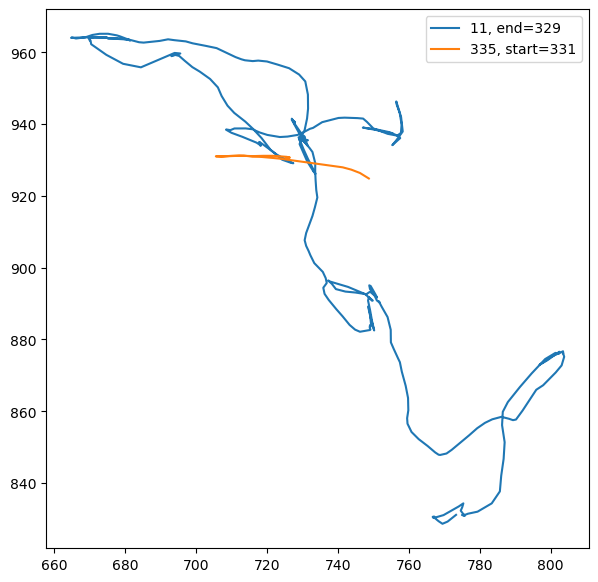

In [31]:

    f=plt.figure(figsize=(7,7)) #creates the figure
    
    ID1=11#stores IDs for the start and end track
    ID2=335#stores IDs for the start and end track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    
    
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])

    #plots the two IDs
    plt.plot(tracksdf[tracksdf.ID==ID1].x,
             tracksdf[tracksdf.ID==ID1].y,label=str(ID1)+", end="+str(startend.loc[ID1].end))
    plt.plot(tracksdf[tracksdf.ID==ID2].x,
             tracksdf[tracksdf.ID==ID2].y,label=str(ID2)+", start="+str(startend.loc[ID2].start))

    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    #print(diff1)
    #print(diff2)
    #print(np.arctan2(diff1[1],diff1[0])*(180/np.pi))
    #print(np.arctan2(diff2[1],diff2[0])*(180/np.pi))
    
    #print(np.min([np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
    #              360-np.abs(np.arctan2(diff1[1],diff1[0])-np.arctan2(diff2[1],diff2[0]))*(180/np.pi)]))
    plt.legend()
    plt.show()

In [16]:
dists=[]
angles=[]
lengths=np.zeros([len(possiblecombos.index),2])
for i in tqdm(range(len(possiblecombos.index))):
    ID1=int(possiblecombos[possiblecombos.index==i].ID1)#stores IDs for the start and end track
    ID2=int(possiblecombos[possiblecombos.index==i].ID2)#stores IDs for the start and end track
    lengths[i,:]=[len(tracksdf[tracksdf.ID==ID1]),len(tracksdf[tracksdf.ID==ID2])] #stores the lengths of each track
    
    #finds the difference between the last points of ID1
    diff1=(tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID1) & (tracksdf.time==startend.loc[ID1].end-1)][["x","y"]].values[0])
    #finds the difference between the first points of ID2
    diff2=(tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start+1)][["x","y"]].values[0]
           -tracksdf[(tracksdf.ID==ID2) & (tracksdf.time==startend.loc[ID2].start)][["x","y"]].values[0])
    #finds the location of the end of ID1
    ID1end=tracksdf[(tracksdf.ID==ID1)&(tracksdf.time==max(tracksdf[tracksdf.ID==ID1].time))][["x","y"]].values[0]
    
    #finds the location of the start of ID2
    ID2start=tracksdf[(tracksdf.ID==ID2)&(tracksdf.time==min(tracksdf[tracksdf.ID==ID2].time))][["x","y"]].values[0]
    
    #finds the distance between the predicted points
    dist = np.sqrt(np.sum(np.square(ID1end+diff1*(int(possiblecombos[possiblecombos.index==i].start)
                                              -int(possiblecombos[possiblecombos.index==i].end))/2
                                    -(ID2start-diff2*(int(possiblecombos[possiblecombos.index==i].start)
                                                  -int(possiblecombos[possiblecombos.index==i].end))/2))))
    angle = np.min([np.abs(np.arctan2(diff1[1],diff1[0])
                           -np.arctan2(diff2[1],diff2[0]))*(180/np.pi),
                    360-np.abs(np.arctan2(diff1[1],diff1[0])
                               -np.arctan2(diff2[1],diff2[0]))*(180/np.pi)])
    dists.append(dist)
    angles.append(angle)

100%|███████████████████████████████████████████████████████████████████████████████| 876/876 [00:06<00:00, 137.60it/s]


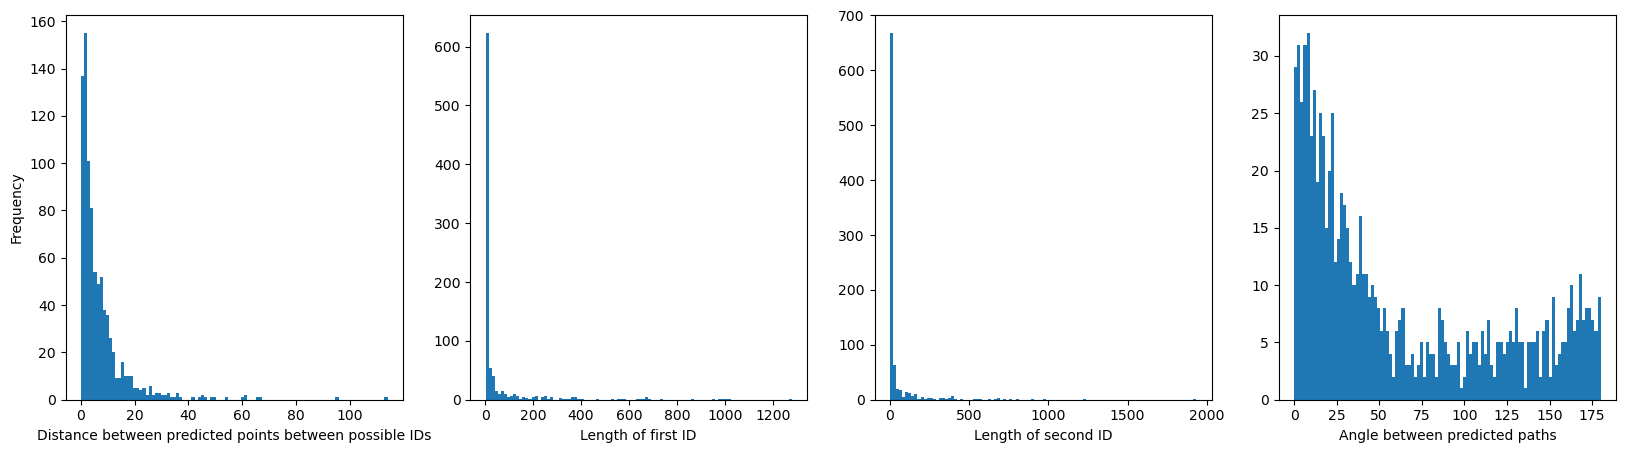

In [17]:
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, sharey=False, figsize=(20,5))
ax1.hist(dists,bins=100)
ax1.set_xlabel("Distance between predicted points between possible IDs")
ax1.set_ylabel("Frequency")


ax2.hist(lengths[:,0],bins=100)
ax2.set_xlabel("Length of first ID")


ax3.hist(lengths[:,1],bins=100)
ax3.set_xlabel("Length of second ID")


ax4.hist(angles,bins=100)
ax4.set_xlabel("Angle between predicted paths");

We should link multiple points that are clearly in a sequence:

In [18]:
confirmeds=np.nonzero((np.asarray(dists)<10)
                      & (np.sum(lengths,axis=1)>=15)
                      & (lengths[:,0]>=4)
                      & (lengths[:,1]>4)
                      & (np.asarray(angles)<60))[0]
if np.any(np.unique(possiblecombos.loc[confirmeds].ID1,return_counts=True)[1]!=1) or np.any(np.unique(possiblecombos.loc[confirmeds].ID2,return_counts=True)[1]!=1):
    print("ERROR: PRELIMINARY CLASSIFICATION FAILED: DUPLICATE MADE")
    
idstodrop=[]
for i in confirmeds: #i represents the index of correct combo
    ID1,ID2=possiblecombos.loc[i][["ID1","ID2"]].values
    tracksdf.loc[tracksdf.ID==ID2,["ID"]]=ID1
    idstodrop.append(np.asarray(possiblecombos[possiblecombos.ID2==ID2].index))

Must run start and end and combos again:

In [19]:
#creates dataframe with start and end times for each ID
startend=pd.DataFrame(columns=["start","end"])
for ID in np.unique(tracksdf.ID).astype(int):
    startend.loc[ID,:]=int(np.min(tracksdf.loc[tracksdf.ID==ID].time)),int(np.max(tracksdf.loc[tracksdf.ID==ID].time))
startend.astype(int);

In [20]:
#gets all possible combinations of two indexes within 10 frames and 20 distance
possiblecombos=pd.DataFrame(columns=["ID1","ID2","end","start"])#,"dist"])
for ID in tqdm(np.unique(tracksdf.ID)):
    endindex=startend.loc[ID].end
    endlocation=tracksdf.loc[(tracksdf.ID==ID) & (tracksdf.time==endindex),["x","y"]].values
    for end in range(endindex,endindex+10):
        if end+1 in list(startend.start):
            for startID in startend.index[startend.start==end+1]:
                startlocation=tracksdf.loc[(tracksdf.ID==startID) & (tracksdf.time==end+1),["x","y"]].values
                if np.linalg.norm(startlocation-endlocation) < 20:
                    possiblecombos.loc[len(possiblecombos.index)] = [int(ID),startID,endindex,end+1]#,np.linalg.norm(startlocation-endlocation)] 
                    #print("first ID: "+str(int(ID))+", second ID: "+str(startID)+", difference in times: "+str(endindex),str(end+1)+", distance: "+str(np.linalg.norm(startlocation-endlocation)))

100%|█████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:05<00:00, 191.66it/s]


In [21]:
combos=[]
for ID in tqdm(np.unique(tracksdf.ID).astype(int)):
    combo=list(np.flip(findpairreverse(ID,[],possiblecombos))[:-1])+findpair(ID,[],possiblecombos)
    len(combo)>1 and combos.append(sorted(combo))

100%|█████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:01<00:00, 798.38it/s]


In [22]:
uniquecombos=[]
for combo in combos:
    if combo not in uniquecombos:
        uniquecombos.append(combo)
combos=uniquecombos

In [23]:
startend.loc[193]

start    115
end      258
Name: 193, dtype: object

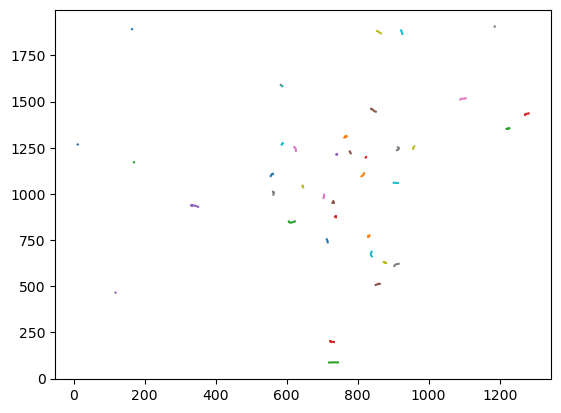

In [24]:
for ID in range(1000):
    vals=tracksdf[(tracksdf.ID==ID)&(tracksdf.time<10)][["x","y"]].values
    plt.plot(vals[:,1],vals[:,0])

In [25]:
x,y=tracksdf[(tracksdf.ID==11)&(tracksdf.time==startend.loc[11].end)][["x","y"]].values[0]

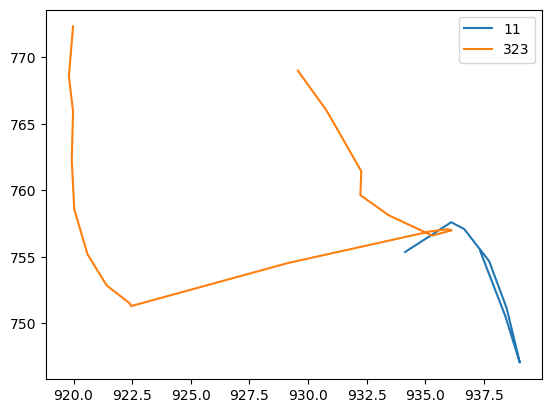

In [26]:
for ID in [11,323]:
    vals=tracksdf[(tracksdf.ID==ID)&(tracksdf.time>320)&(tracksdf.time<340)][["x","y"]].values
    plt.plot(vals[:,1],vals[:,0],label=ID)
plt.legend()

In [100]:
dist=100
tracksdf[(tracksdf.time==startend.loc[11].end+2)&(tracksdf.x<x+dist)&(tracksdf.x>x-dist)&(tracksdf.y<y+dist)&(tracksdf.y>y-dist)]

ID   time           x           y
21155  323.0  331.0  756.913793  935.224138
21287  335.0  331.0  748.752688  924.849462

In [76]:
startend.loc[11]

start      0
end      329
Name: 11, dtype: object

In [ ]:
sumarray=np.zeros(np.shape(images["1"]['frame'][0].max(2)))
for i in tqdm(np.asarray(list(images.keys()))[:-1]):
    sumarray+=images[i]['frame'][0].max(2)

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4197/4313 [02:56<00:02, 44.50it/s]

In [6]:
images = h5py.File("../data/202304051.h5",'r+') 

In [11]:
sumarray=np.load("sumarray.npy")

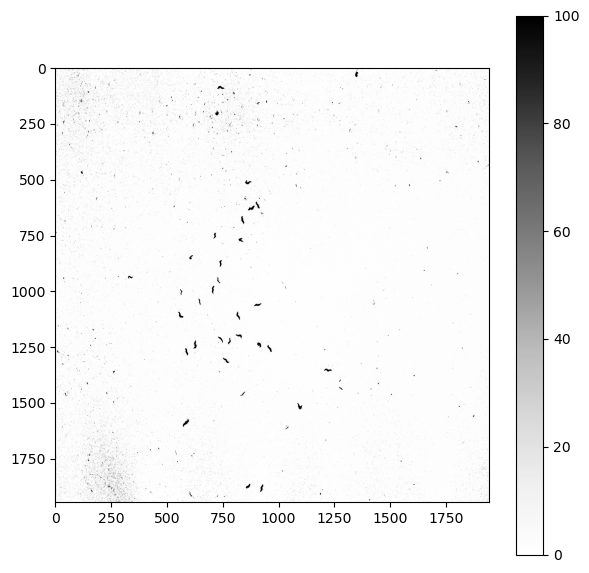

In [12]:
fig=plt.figure(figsize=(7,7))
img=images["2"]['frame'][0].max(2)-sumarray/max(np.asarray(list(images.keys()))[:-1].astype(int))
img=np.vectorize(lambda x: 0 if x < 0 else x)(img)
img=np.vectorize(lambda x: 100 if x > 5 else x)(img)
plt.imshow(img,cmap="Greys")
plt.colorbar()